In [3]:
from __future__ import annotations

from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

import scipy.stats as stats

from typing import Optional, Any, Tuple

### Some functions

In [4]:
def assign_random_variant(
    df, variant_col, random_seed=42, num_samples=None, replace=True
):
    np.random.seed(random_seed)
    if num_samples:
        df = df.sample(num_samples, replace=replace)
    df[variant_col] = np.random.choice(
        ["control", "treatment"], size=df.shape[0], p=[0.5, 0.5]
    )
    return df


def bootstrap_differences(
    df,
    variant_col,
    value_col,
    variant1="treatment",
    variant2="control",
    iterations=100,
    num_samples=None,
):
    means_s = []
    for i in range(iterations):
        df_random = assign_random_variant(
            df, variant_col, random_seed=i, num_samples=num_samples
        )
        this_mean = (
            df_random.loc[df_random[variant_col] == variant1][value_col].mean()
            - df_random.loc[df_random[variant_col] == variant2][value_col].mean()
        )
        means_s.append(this_mean)
    means_s = pd.Series(means_s)
    return means_s

In [15]:
confidence = 0.95


def get_frequency_tables(data, variant_col, value_col, count_col="user_id"):
    frequency_table = (
        data.groupby([variant_col, value_col])[count_col]
        .count()
        .reset_index()
        .rename(columns={count_col: "count"})
    )
    variants = frequency_table["variant"].unique()
    variant_dict = {}
    for v in variants:
        variant_dict[v] = Variant(v)
        variant_dict[v].add_frequency_table(
            frequency_table.loc[frequency_table["variant"] == v]
        )
        variant_dict[v].frequency_table = variant_dict[v].frequency_table.drop(
            columns="variant"
        )

    return variant_dict


@dataclass
class Variant:
    tag: str
    frequency_table: pd.DataFrame  # = pd.DataFrame({})

    def add_frequency_table(
        self,
        frequency: pd.DataFrame,
    ):
        self.frequency_table = frequency


def redraw(count: npt.NDArray[Any], n: int = 1_000) -> npt.NDArray[Any]:
    return np.random.multinomial(count.sum(), count / count.sum(), size=n)


def expected(x: npt.NDArray[Any], counts: npt.NDArray[Any]) -> npt.NDArray[Any]:
    return (counts * x).sum(axis=1) / counts.sum(axis=1)


@dataclass
class CountsTable:
    counts: npt.NDArray[Any]
    values: pd.DataFrame

    @classmethod
    def from_frequency(cls, freq: pd.DataFrame) -> CountsTable:
        return cls(np.array([freq["count"].values]), freq.drop("count", axis=1))

    def unbias(self) -> CountsTable:
        # Shift values by removing a constant so the first draw in the CountsTable has mean = 0
        if len(self.counts) > 1:
            raise RuntimeError("Can only unbias CountsTable with only one count")
        if len(self.values.values.T) > 1:
            raise RuntimeError("Can only unbias CountsTable with only one value")
        return CountsTable(
            self.counts, self.values - expected(self.values.values.T, self.counts)[0]
        )

    def redraw(self, n: int = 1) -> CountsTable:
        # Redraw `n` times from the first column of counts
        return CountsTable(redraw(self.counts[0], n), self.values)


decimal_places = lambda x: -int(math.floor(math.log10(abs(x)))) + 1


@dataclass
class ValueWithPercentile:
    mean: float
    low_perc: float
    high_perc: float

    def __str__(self):
        places = decimal_places(self.high_perc - self.low_perc)
        return (
            f"[{round(self.low_perc*100, places)} | {round(self.mean*100, places)} | "
            f"{round(self.high_perc*100, places)}]"
        )


@dataclass
class ValueWithCI:
    mean: float
    low_ci: float
    high_ci: float

    def __str__(self):
        places = decimal_places(self.high_ci - self.low_ci)
        return (
            f"[{round(self.low_ci, places)} | {round(self.mean, places)} | "
            f"{round(self.high_ci, places)}]"
        )


def t_statistic(count_a: CountsTable, count_b: CountsTable) -> Tuple[Any, Any, Any]:
    mean_a = expected(count_a.values.values.T, count_a.counts)
    mean_b = expected(count_b.values.values.T, count_b.counts)
    var_a = expected(count_a.values.values.T**2, count_a.counts) - mean_a**2
    var_b = expected(count_b.values.values.T**2, count_b.counts) - mean_b**2
    n_a = count_a.counts.sum(axis=1)
    n_b = count_b.counts.sum(axis=1)
    return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b


def t_statistic_bootstrap(
    control_freq: pd.DataFrame,
    treatment_freq: pd.DataFrame,
    metric: str = "value",
    decimal_places: Optional[int] = None,
):
    control = CountsTable.from_frequency(control_freq)
    treatment = CountsTable.from_frequency(treatment_freq)
    stats_base = t_statistic(treatment, control)
    t_base = stats_base[0][0]
    m_base_t = stats_base[1][0]
    m_base_c = stats_base[2][0]
    c_redraw = control.unbias().redraw(1_000)
    t_redraw = treatment.unbias().redraw(1_000)
    stats_bootstrap = t_statistic(t_redraw, c_redraw)
    t_bootstrap = stats_bootstrap[0]
    m_bootstrap_t = stats_bootstrap[1]
    m_bootstrap_c = stats_bootstrap[2]
    return t_base, m_base_t, m_base_c, t_bootstrap, m_bootstrap_t, m_bootstrap_c


def bootstrap_mean(frequency):
    count = CountsTable.from_frequency(frequency)
    c_redraw = count.redraw(1_000)
    c_mean = c_redraw.counts @ c_redraw.values.values / sum(c_redraw.counts.T)[0]
    c_mean_df = pd.DataFrame(data=c_mean, columns=count.values.columns)
    return c_mean_df


def et_test(
    variants: dict[str, Variant],
    show_plots: bool = False,
    confidence: float = confidence,
    alternative: str = "two-sided",
):
    variant_a, variant_b = variants["control"], variants["treatment"]
    (
        t_base,
        m_base_t,
        m_base_c,
        t_bootstrap,
        m_bootstrap_t,
        m_bootstrap_c,
    ) = t_statistic_bootstrap(variant_a.frequency_table, variant_b.frequency_table)
    m_base = m_base_t - m_base_c
    resample_se_t = np.std(m_bootstrap_t)
    resample_se_c = np.std(m_bootstrap_c)
    resample_se = np.sqrt(resample_se_t**2 + resample_se_c**2)
    lower_q, upper_q = np.percentile(
        t_bootstrap, [(1 - confidence) / 2 * 100, (1 + confidence) / 2 * 100]
    )
    p_value_right = np.mean(t_bootstrap > t_base)
    p_value_left = np.mean(t_bootstrap < t_base)
    p_value_twosided = np.mean(abs(t_bootstrap) > abs(t_base))
    absolute_impact = ValueWithCI(
        m_base, m_base - resample_se * upper_q, m_base - resample_se * lower_q
    )
    resample_cv_t = resample_se_t / m_base_t
    resample_cv_c = resample_se_c / m_base_c
    rel_diff = (m_base_t - m_base_c) / abs(m_base_c)
    result = {
        "p_value_right": p_value_right,
        "p_value_left": p_value_left,
        "p_value_twosided": p_value_twosided,
    }
    # Calculate the p-value
    if alternative == "two-sided":
        p_value = p_value_twosided
    elif alternative == "less":
        p_value = p_value_left
    elif alternative == "greater":
        p_value = p_value_right
    else:
        raise ValueError(
            "Invalid alternative hypothesis. Possible values are 'two-sided', 'less' or 'greater'."
        )

    # Determine whether to reject the null hypothesis
    reject_null = p_value < 1 - confidence

    return p_value, reject_null


def percentile_test(
    variants: dict[str, Variant],
    show_plots: bool = False,
    confidence: float = 0.95,
    alternative="two-sided",
):
    histogram = {}
    variant_a, variant_b = variants["control"], variants["treatment"]
    for variant in [variant_a, variant_b]:
        bootstrap = bootstrap_mean(variant.frequency_table)
        histogram[variant.tag] = bootstrap.iloc[:, 0]

    p_value_right = np.mean(
        histogram[variant_a.tag] >= histogram[variant_b.tag], axis=0
    )
    p_value_left = np.mean(histogram[variant_b.tag] >= histogram[variant_a.tag], axis=0)
    p_value_twosided = np.mean(
        abs(histogram[variant_a.tag]) >= abs(histogram[variant_b.tag]), axis=0
    )
    result = {
        "p_value_right": p_value_right,
        "p_value_left": p_value_left,
    }

    # Calculate the p-value
    if alternative == "two-sided":
        p_value = np.nan
    elif alternative == "less":
        p_value = p_value_left
    elif alternative == "greater":
        p_value = p_value_right
    else:
        raise ValueError(
            "Invalid alternative hypothesis. Possible values are 'two-sided', 'less' or 'greater'."
        )

    # Determine whether to reject the null hypothesis
    reject_null = p_value < 1 - confidence

    return p_value, reject_null

In [10]:
def z_test_mean_diff(
    df,
    variant_col,
    value_col,
    variant1="treatment",
    variant2="control",
    alpha=0.05,
    alternative="two-sided",
):
    """
    Perform a two-sample z-test for the mean difference between two samples in a pandas DataFrame.

    Parameters:
    -----------
    df: pandas DataFrame
        The DataFrame containing the data.
    variant_col: str
        The name of the column containing the variant labels.
    value_col: str
        The name of the column containing the values to compare.
    variant1: str
        The label for the first variant.
    variant2: str
        The label for the second variant.
    alpha: float, optional
        The significance level. Default is 0.05.
    alternative: str, optional
        The alternative hypothesis. Possible values are 'two-sided', 'less' or 'greater'.
        Default is 'two-sided'.

    Returns:
    --------
    z_score: float
        The z-score.
    p_value: float
        The p-value.
    reject_null: bool
        Whether to reject the null hypothesis or not.
    """

    # Separate the two samples based on the variant column
    sample1 = df[df[variant_col] == variant1][value_col]
    sample2 = df[df[variant_col] == variant2][value_col]

    # Calculate the sample means and standard deviations
    mean1 = sample1.mean()
    mean2 = sample2.mean()
    std1 = sample1.std()
    std2 = sample2.std()

    # Calculate the pooled standard deviation
    try:
        pooled_std = ((std1**2) / len(sample1) + (std2**2) / len(sample2)) ** 0.5
    except ZeroDivisionError:
        pooled_std = 0
    # Calculate the z-score
    try:
        z_score = (mean1 - mean2) / pooled_std
    except ZeroDivisionError:
        z_score = 0.5

    # Calculate the p-value
    if alternative == "two-sided":
        p_value = stats.norm.sf(abs(z_score)) * 2
    elif alternative == "less":
        p_value = stats.norm.cdf(z_score)
    elif alternative == "greater":
        p_value = stats.norm.sf(z_score)
    else:
        raise ValueError(
            "Invalid alternative hypothesis. Possible values are 'two-sided', 'less' or 'greater'."
        )

    # Determine whether to reject the null hypothesis
    reject_null = p_value < alpha

    return z_score, p_value, reject_null


def t_test_mean_diff(
    df,
    variant_col,
    value_col,
    variant1="treatment",
    variant2="control",
    alpha=0.05,
    alternative="two-sided",
):
    """
    Performs a two-sample t-test for the mean difference between two variants.
    Inputs:
        - df: pandas DataFrame containing the data
        - variant_col: string, name of the column that indicates the variant ('control' or 'treatment')
        - value_col: string, name of the column containing the values to compare
    Returns:
        - tuple (t_statistic, p_value)
    """
    control_values = df[df[variant_col] == variant1][value_col]
    treatment_values = df[df[variant_col] == variant2][value_col]
    t_statistic, p_value = stats.ttest_ind(
        control_values, treatment_values, alternative=alternative
    )

    # Determine whether to reject the null hypothesis
    reject_null = p_value < alpha

    return t_statistic, p_value, reject_null


# Define the function to apply the z-test to multiple dataframes
def run_test_mean_diff_multiple(
    df,
    variant_col,
    value_col,
    number_of_tests=100,
    num_samples=None,
    alternative="two-sided",
    effect=0,
):
    # Initialize an empty DataFrame to store the results
    results_df = pd.DataFrame(
        columns=[
            "test_number",
            "z_score",
            "z_p_value",
            "z_reject_null",
            "t_score",
            "t_p_value",
            "t_reject_null",
        ]
    )

    # Iterate over pairs of dataframes
    for i in range(number_of_tests):
        random_df = assign_random_variant(
            df, variant_col, random_seed=i, num_samples=num_samples
        )
        random_df[value_col] = np.where(
            random_df[variant_col] == "treatment",
            random_df[value_col] * (1 + effect),
            random_df[value_col],
        )
        # Apply the z-test to the pair of dataframes
        z_score, z_p_value, z_reject_null = z_test_mean_diff(
            random_df,
            variant_col=variant_col,
            alpha=1 - confidence,
            value_col=value_col,
            alternative=alternative,
        )

        # Apply the t-test to the pair of dataframes
        t_score, t_p_value, t_reject_null = t_test_mean_diff(
            random_df,
            variant_col=variant_col,
            alpha=1 - confidence,
            value_col=value_col,
            alternative=alternative,
        )

        # Apply the percentile bootstrap test to the pair of dataframes
        variant_dict = get_frequency_tables(
            random_df, variant_col="variant", value_col="total_sales"
        )

        percentile_p_value, percentile_reject_null = percentile_test(
            variant_dict, alternative=alternative
        )
        et_p_value, et_reject_null = et_test(variant_dict, alternative=alternative)

        # Add the results to the DataFrame
        this_results = pd.DataFrame(
            {
                "test_number": i,
                "z_score": z_score,
                "z_p_value": z_p_value,
                "z_reject_null": z_reject_null,
                "t_score": t_score,
                "t_p_value": t_p_value,
                "t_reject_null": t_reject_null,
                "percentile_p_value": percentile_p_value,
                "percentile_reject_null": percentile_reject_null,
                "et_p_value": et_p_value,
                "et_reject_null": et_reject_null,
            },
            index=[0],
        )
        results_df = pd.concat([results_df, this_results])

    # Return the results DataFrame
    return results_df

In [ ]:
events_df = pd.read_csv("Data/2019-Oct.csv")

In [ ]:
events_df["time"] = pd.to_datetime(events_df["event_time"])
events_df["date"] = events_df["time"].dt.date
events_df["sales"] = np.where(
    events_df["event_type"] == "purchase", events_df["price"], 0
)
events_df = pd.get_dummies(data=events_df, columns=["event_type"])
events_df.head()

,event_time,product_id,category_id,category_code,brand,price,user_id,user_session,time,date,sales,event_type_cart,event_type_purchase,event_type_remove_from_cart,event_type_view
0,2019-10-01 00:00:00 UTC,5773203,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:00+00:00,2019-10-01,0.0,1,0,0,0
1,2019-10-01 00:00:03 UTC,5773353,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:03+00:00,2019-10-01,0.0,1,0,0,0
2,2019-10-01 00:00:07 UTC,5881589,2151191071051219817,NaN,lovely,13.48,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:07+00:00,2019-10-01,0.0,1,0,0,0
3,2019-10-01 00:00:07 UTC,5723490,1487580005134238553,NaN,runail,2.62,463240011,26dd6e6e-4dac-4778-8d2c-92e149dab885,2019-10-01 00:00:07+00:00,2019-10-01,0.0,1,0,0,0
4,2019-10-01 00:00:15 UTC,5881449,1487580013522845895,NaN,lovely,0.56,429681830,49e8d843-adf3-428b-a2c3-fe8bc6a307c9,2019-10-01 00:00:15+00:00,2019-10-01,0.0,1,0,0,0


<Axes: xlabel='date'>

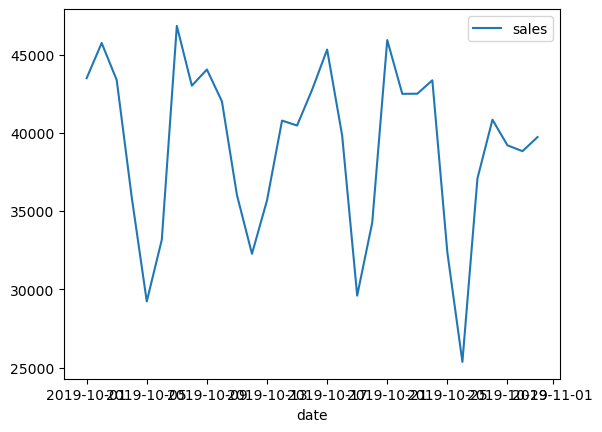

In [ ]:
events_by_date = events_df.groupby("date").sum().reset_index()
events_by_date.plot(x="date", y="sales", kind="line")

In [ ]:
users_df = events_df.groupby("user_id").agg(
    {
        "user_id": ["size"],
        "sales": ["sum"],
        "event_type_view": ["sum", "max"],
        "event_type_cart": ["sum", "max"],
        "event_type_remove_from_cart": ["sum", "max"],
        "event_type_purchase": ["sum", "max"],
        "date": ["min", "max"],
    }
)
users_df.columns = ["_".join(col).strip() for col in users_df.columns.values]
users_df = users_df.rename(
    columns={
        "user_id_size": "num_events",
        "sales_sum": "total_sales",
        "event_type_view_sum": "total_views",
        "event_type_view_max": "has_view",
        "event_type_cart_sum": "total_cart",
        "event_type_cart_max": "has_cart",
        "event_type_remove_from_cart_sum": "total_remove_from_cart",
        "event_type_remove_from_cart_max": "has_remove_from_cart",
        "event_type_purchase_sum": "total_purchases",
        "event_type_purchase_max": "has_purchases",
    }
).reset_index()
users_df[(users_df["has_purchases"] >= 1) & (users_df["has_view"] == 1)]  # .columns
users_df = assign_random_variant(users_df, variant_col="variant")

,user_id,num_events,total_sales,total_views,has_view,total_cart,has_cart,total_remove_from_cart,has_remove_from_cart,total_purchases,has_purchases,date_min,date_max
31,29025780,52,41.68,3.0,1,29.0,1,2.0,1,18.0,1,2019-10-02,2019-10-07
40,31229488,53,14.43,27.0,1,7.0,1,15.0,1,4.0,1,2019-10-03,2019-10-03
47,33535391,45,138.88,16.0,1,14.0,1,4.0,1,11.0,1,2019-10-13,2019-10-13
48,33609704,53,31.31,30.0,1,12.0,1,2.0,1,9.0,1,2019-10-04,2019-10-24
53,34080306,42,16.75,22.0,1,11.0,1,6.0,1,3.0,1,2019-10-30,2019-10-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399509,566264460,36,9.74,20.0,1,8.0,1,2.0,1,6.0,1,2019-10-31,2019-10-31
399588,566270279,48,32.74,9.0,1,16.0,1,17.0,1,6.0,1,2019-10-31,2019-10-31
399592,566270544,3,19.84,1.0,1,1.0,1,0.0,0,1.0,1,2019-10-31,2019-10-31
399612,566272734,21,10.79,7.0,1,7.0,1,0.0,0,7.0,1,2019-10-31,2019-10-31


<Axes: ylabel='Frequency'>

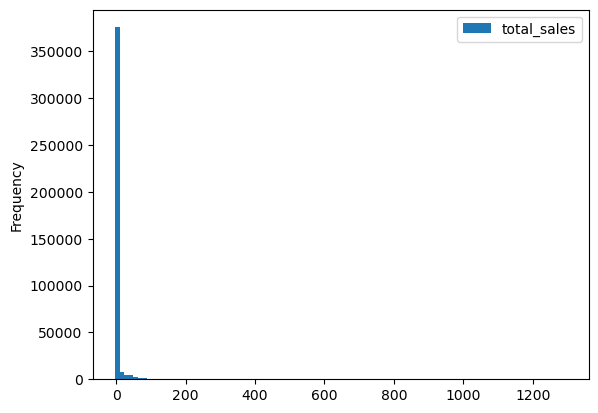

In [ ]:
# Distribucion de ventas
users_df.plot.hist(y="total_sales", bins=100)

<Axes: ylabel='Frequency'>

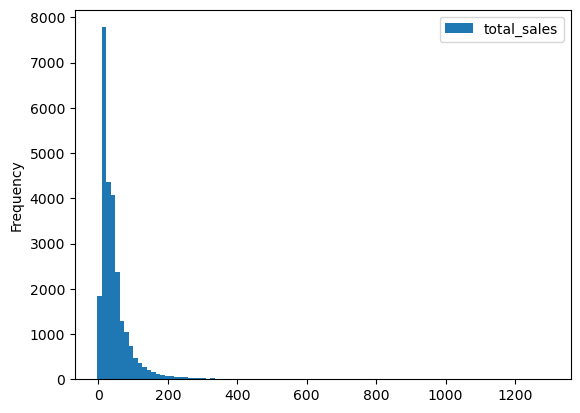

In [ ]:
# Distribución de ventas para usuarios que compraron
users_df[users_df["total_sales"] != 0].plot.hist(y="total_sales", bins=100)

In [ ]:
users_df.describe()

,user_id,num_events,total_sales,total_views,has_view,total_cart,has_cart,total_remove_from_cart,has_remove_from_cart,total_purchases,has_purchases
count,3.996640e+05,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000,399664.000000
mean,5.288604e+08,10.264330,3.031392,4.659324,0.971644,3.083553,0.334826,1.906877,0.117824,0.614576,0.064459
std,6.374482e+07,39.189611,18.257283,17.695189,0.165989,12.649916,0.471930,14.416924,0.322400,3.711174,0.245569
min,4.103071e+06,1.000000,-3.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.295908e+08,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.571228e+08,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.607882e+08,4.000000,0.000000,3.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,5.662808e+08,3965.000000,1295.480000,3086.000000,1.000000,1129.000000,1.000000,2783.000000,1.000000,329.000000,1.000000


In [ ]:
users_df.loc[users_df["has_purchases"] == 1].describe()

,user_id,num_events,total_sales,total_views,has_view,total_cart,has_cart,total_remove_from_cart,has_remove_from_cart,total_purchases,has_purchases
count,2.576200e+04,25762.000000,25762.000000,25762.000000,25762.000000,25762.000000,25762.000000,25762.000000,25762.000000,25762.000000,25762.0
mean,4.975684e+08,71.331690,47.028120,24.709728,0.935603,21.134423,0.986841,15.953187,0.792757,9.534353,1.0
std,8.572289e+07,110.628724,55.697229,49.743400,0.245464,32.672519,0.113957,43.732120,0.405339,11.341405,0.0
min,2.902578e+07,1.000000,-3.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0
25%,4.630881e+08,17.000000,16.490000,3.000000,1.000000,5.000000,1.000000,1.000000,1.000000,3.000000,1.0
50%,5.372417e+08,38.000000,32.380000,10.000000,1.000000,11.000000,1.000000,4.000000,1.000000,6.000000,1.0
75%,5.580677e+08,83.000000,54.947500,26.000000,1.000000,25.000000,1.000000,15.000000,1.000000,12.000000,1.0
max,5.662742e+08,3965.000000,1295.480000,2124.000000,1.000000,1107.000000,1.000000,2783.000000,1.000000,329.000000,1.0


## Normality

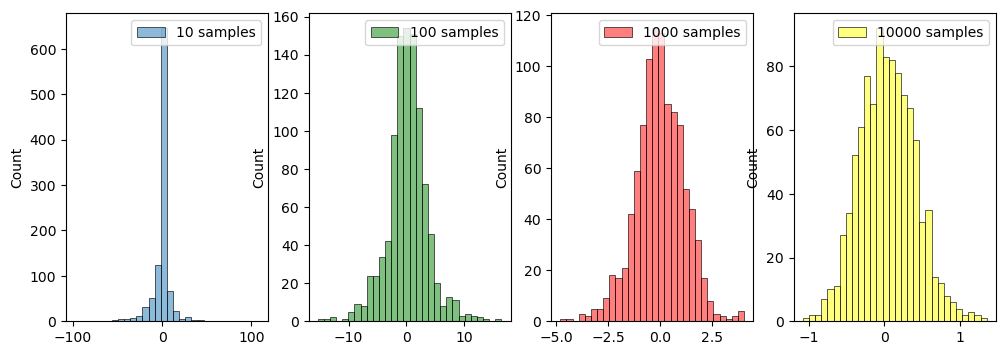

In [ ]:
iterations = 1000
diffs_10 = bootstrap_differences(
    users_df,
    variant_col="variant",
    value_col="total_sales",
    iterations=iterations,
    num_samples=10,
)
diffs_100 = bootstrap_differences(
    users_df,
    variant_col="variant",
    value_col="total_sales",
    iterations=iterations,
    num_samples=100,
)
diffs_1000 = bootstrap_differences(
    users_df,
    variant_col="variant",
    value_col="total_sales",
    iterations=iterations,
    num_samples=1000,
)
diffs_10000 = bootstrap_differences(
    users_df,
    variant_col="variant",
    value_col="total_sales",
    iterations=iterations,
    num_samples=10000,
)

fig, ax = plt.subplots(1, 4, figsize=(12, 4))
sns.histplot(diffs_10, bins=30, label=f"10 samples", ax=ax[0], alpha=0.5)
sns.histplot(
    diffs_100, bins=30, label=f"100 samples", ax=ax[1], color="green", alpha=0.5
)
sns.histplot(
    diffs_1000, bins=30, label=f"1000 samples", ax=ax[2], color="red", alpha=0.5
)
sns.histplot(
    diffs_10000, bins=30, label=f"10000 samples", ax=ax[3], color="yellow", alpha=0.5
)

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

In [ ]:
# Test if the data follows a normal distribution
statistic, p_value = stats.normaltest(diffs_1000)

# Print the test statistic and p-value
print(f"Test statistic: {statistic}")
print(f"P-value: {p_value}")

Test statistic: 18.374015437378787
P-value: 0.00010236069891475584


In [ ]:
# Test if the data follows a normal distribution
statistic, p_value = stats.shapiro(diffs_10000)

# Print the test statistic and p-value
print(f"Test statistic: {statistic}")
print(f"P-value: {p_value}")

Test statistic: 0.9971159100532532
P-value: 0.06923049688339233


In [ ]:
# Test if the data follows a normal distribution
statistic, p_value = stats.kstest(diffs_1000, "norm")

# Print the test statistic and p-value
print(f"Test statistic: {statistic}")
print(f"P-value: {p_value}")

Test statistic: 0.03605765880166467
P-value: 0.14489311079894052


## AA

In [ ]:
experiments = 1000
samples = 1000

p_values_AA = run_test_mean_diff_multiple(
    users_df,
    variant_col="variant",
    value_col="total_sales",
    number_of_tests=experiments,
    num_samples=samples,
    alternative="greater",
)
p_values_AA = p_values_AA.reset_index(drop=True)
p_values_AA

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divi

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divi

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWar

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return (

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:160: RuntimeWarning: invalid value encountered in double_scalars
  resample_cv_c = resample_se_c / m_base_c
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:161: RuntimeWarning: divide by zero encountered in double_scalars
  rel_diff = (m_base_t - m_base_c) / abs(m_base_c)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:159: RuntimeWarning: invalid value encountered in double_scalars
  resample_cv_t = resample_se_t /

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by ze

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return (

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divi

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encou

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:160: RuntimeWarning: invalid value encountered in double_scalars
  resample_cv_c 

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:160: RuntimeWarning: invalid value encountered in double_scalars
  resample_cv_c = resample_se_c / m_base_c
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:161: RuntimeWarning: divide by zero encountered in double_scalars
  rel_diff = (m_base_t - m_base_c) / abs(m_base_c)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b)

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWar

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:159: RuntimeWarning: invalid value encountered in double_scalars
  resample_cv_t = resample_se_t / m_base_t
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid valu

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: in

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return (

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by ze

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:159: RuntimeWarning: invalid value encountered in double_scalars
  resamp

,test_number,z_score,z_p_value,z_reject_null,t_score,t_p_value,t_reject_null,percentile_p_value,percentile_reject_null,et_p_value,et_reject_null
0,0,0.909050,0.181662,False,0.789740,0.215793,False,0.164,False,0.148,False
1,1,0.354815,0.361364,False,0.399928,0.345040,False,0.424,False,0.304,False
2,2,-0.541212,0.705819,False,-0.536242,0.703497,False,0.707,False,0.740,False
3,3,-0.410396,0.659242,False,-0.418358,0.661700,False,0.637,False,0.663,False
4,4,0.210043,0.416817,False,0.224527,0.411408,False,0.411,False,0.377,False
...,...,...,...,...,...,...,...,...,...,...,...
995,995,-1.663901,0.951934,False,-1.503661,0.932058,False,1.000,False,0.986,False
996,996,-2.243876,0.987580,False,-1.913935,0.970727,False,0.999,False,0.999,False
997,997,1.470788,0.070674,False,1.701250,0.046033,True,0.064,False,0.028,True
998,998,1.585992,0.056371,False,1.524181,0.065342,False,0.009,True,0.011,True


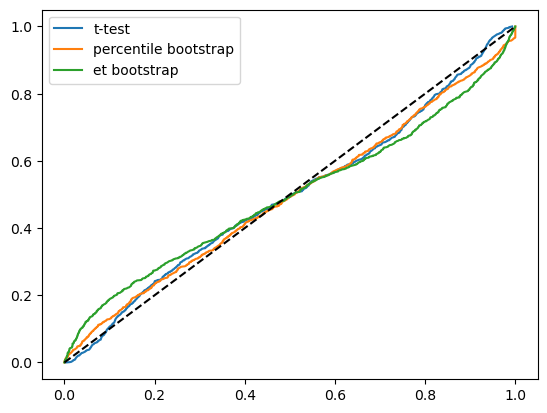

In [ ]:
fig, ax = plt.subplots()
# ax.plot(sorted(p_values_AA["z_p_value"]), np.linspace(0, 1, experiments), label="z-test")
ax.plot(
    sorted(p_values_AA["t_p_value"]), np.linspace(0, 1, experiments), label="t-test"
)
ax.plot(
    sorted(p_values_AA["percentile_p_value"]),
    np.linspace(0, 1, experiments),
    label="percentile bootstrap",
)
ax.plot(
    sorted(p_values_AA["et_p_value"]),
    np.linspace(0, 1, experiments),
    label="et bootstrap",
)
ax.legend()
ax.plot([0, 1], [0, 1], "--k")

## AB

In [ ]:
experiments = 1000
samples = 100

p_values_AB = run_test_mean_diff_multiple(
    users_df,
    variant_col="variant",
    value_col="total_sales",
    number_of_tests=experiments,
    num_samples=samples,
    alternative="greater",
    effect=2,
)
p_values_AB = p_values_AB.reset_index(drop=True)
p_values_AB

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divi

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divi

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return (

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return (

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:160: RuntimeWarning: invalid value encountered in double_scalars
  resample_cv_c = resample_se_c / m_base_c
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:161: RuntimeWarning: divide by zero encountered in double_scalars
  rel_diff = (m_base_t - m_base_c) / abs(m_base_c)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:159: RuntimeWarning: invalid value encountered in double_scalars
  resample_cv_t = resample_se_t / m_base_t
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encou

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:160: RuntimeWarning: invalid value encountered in double_scalars
  resample_cv_c = resample_se_c / m_base_c
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:161: RuntimeWarning: divide by zero encountered in double_scalars
  rel_diff = (m_base_t - m_base_c) / abs(m_b

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return (

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWar

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:160: RuntimeWarning: invalid value encountered in double_scalars
  resample_cv_c = resample_se_c / m_base_c
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:161: RuntimeWarning: divide by zero encountered in double_scalars
  rel_diff = (m_base_t - m_base_c) / abs(m_base_c)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a - mean_b) / np.sq

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  di

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a 

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by ze

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a 

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: in

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: invalid value encountered in sqrt
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encou

/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/Users/batiferraro/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return ((mean_a - mean_b) / np.sqrt(var_a / n_a + var_b / n_b)), mean_a, mean_b
/var/folders/5f/6fxk1_pj3x7fjyr0gbxq0qhw0000gn/T/ipykernel_17086/3530389424.py:109: RuntimeWarning: divide by zero encountered in true_divide
  return (

,test_number,z_score,z_p_value,z_reject_null,t_score,t_p_value,t_reject_null,percentile_p_value,percentile_reject_null,et_p_value,et_reject_null
0,0,1.379282,0.083904,False,1.154145,0.125624,False,0.068,False,0.029,True
1,1,0.787225,0.215575,False,0.955285,0.170892,False,0.365,False,0.123,False
2,2,0.444130,0.328474,False,0.449012,0.327207,False,0.388,False,0.330,False
3,3,0.846965,0.198507,False,0.762037,0.223934,False,0.202,False,0.136,False
4,4,1.008207,0.156677,False,1.169766,0.122466,False,0.135,False,0.100,False
...,...,...,...,...,...,...,...,...,...,...,...
995,995,-1.663901,0.951934,False,-1.503661,0.932058,False,1.000,False,0.986,False
996,996,-1.708172,0.956198,False,-1.496976,0.931193,False,0.958,False,0.983,False
997,997,1.959010,0.025056,True,2.387036,0.009452,True,0.006,True,0.006,True
998,998,1.681541,0.046329,True,1.615058,0.054757,False,0.006,True,0.006,True


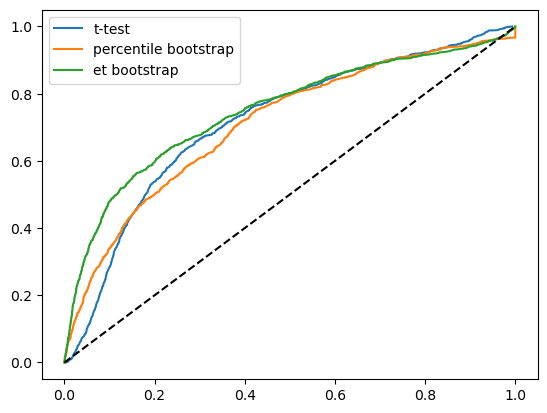

In [ ]:
fig, ax = plt.subplots()
# ax.plot(sorted(p_values_AB["z_p_value"]), np.linspace(0, 1, experiments), label="z-test")
ax.plot(
    sorted(p_values_AB["t_p_value"]), np.linspace(0, 1, experiments), label="t-test"
)
ax.plot(
    sorted(p_values_AB["percentile_p_value"]),
    np.linspace(0, 1, experiments),
    label="percentile bootstrap",
)
ax.plot(
    sorted(p_values_AB["et_p_value"]),
    np.linspace(0, 1, experiments),
    label="et bootstrap",
)
ax.legend()
ax.plot([0, 1], [0, 1], "--k")

In [ ]:
p_values_AB.sort_values(by="t_p_value")

,test_number,z_score,z_p_value,z_reject_null,t_score,t_p_value,t_reject_null,percentile_p_value,percentile_reject_null,et_p_value,et_reject_null
963,963,2.438883,0.007366,True,2.990539,0.001761,True,0.000,True,0.001,True
479,479,2.709778,0.003366,True,2.561703,0.005970,True,0.000,True,0.000,True
471,471,2.424690,0.007661,True,2.470783,0.007604,True,0.001,True,0.003,True
791,791,2.371581,0.008856,True,2.465863,0.007703,True,0.001,True,0.003,True
690,690,2.395094,0.008308,True,2.443153,0.008175,True,0.002,True,0.001,True
...,...,...,...,...,...,...,...,...,...,...,...
889,889,-2.489521,0.993604,False,-2.029237,0.977427,False,1.000,False,1.000,False
737,737,-1.728656,0.958065,False,-2.035371,0.977743,False,1.000,False,0.997,False
462,462,-1.930003,0.973197,False,-2.112672,0.981415,False,0.982,False,0.993,False
90,90,-2.024425,0.978537,False,-2.240628,0.986346,False,1.000,False,0.994,False
